In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Prepare for Dataset

In [2]:
# Get a random sequence of sine curve.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    # Sample a sequence.
    t = np.arange(0, seq_len) 
    a = 2*np.pi*1.0/seq_len
    b = 2*np.pi*np.random.rand()*5 
    seq = np.sin(a*t+b)
    return seq

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = torch.tensor(seq[:-1]).float().view(-1,1,1) # Input sequence.
    target = torch.tensor(seq[1:]).float().view(-1,1,1)  # Target sequence.
    return input, target

#### Choose a Device

In [3]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

mps


#### Network Definition

In [4]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = 1###### To be filled ######
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = 1###### To be filled ######

        ###FILLED###
        self.rnn_cell = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        ###FILLED###

    def forward(self, input, hidden):
        """ Forward function.
              input:  Input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """

        # Forward function.
        hidden = self.rnn_cell(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn_cell): RNNCell(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

#### Training Step and Evaluation Step

In [5]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, 1].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [6]:
# Evaluation step function.
def eval_step(net, predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_seq      = get_random_seq()
    init_input    = torch.tensor(init_seq).float().view(-1,1,1).to(device)
    predicted_seq = []

    # Use initial points on the curve to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more points after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Add predicted point to the sequence and use it as next input.
        predicted_seq.append(output.item())
        
        # Use the predicted point to generate the input of next round.
        input = output

    return init_seq, predicted_seq

#### Training Procedure

In [7]:
# Number of iterations.
iters       = 200    # Number of training iterations.
print_iters = 10     # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.MSELoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        #print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:9/200 loss:0.22591301798820496
iter:19/200 loss:0.03411274030804634
iter:29/200 loss:0.009617986157536507
iter:39/200 loss:0.005381282884627581
iter:49/200 loss:0.0033713895827531815
iter:59/200 loss:0.0030638733878731728
iter:69/200 loss:0.0028117839246988297
iter:79/200 loss:0.0020837055053561926
iter:89/200 loss:0.0023014729376882315
iter:99/200 loss:0.002544430550187826
iter:109/200 loss:0.0022301762364804745
iter:119/200 loss:0.0016230341279879212
iter:129/200 loss:0.0018837429815903306
iter:139/200 loss:0.0019268527394160628
iter:149/200 loss:0.0014777010073885322
iter:159/200 loss:0.0016627352451905608
iter:169/200 loss:0.0017195919062942266
iter:179/200 loss:0.0017226511845365167
iter:189/200 loss:0.0020515015348792076
iter:199/200 loss:0.001920025097206235


#### Training Loss Curve

In [8]:
all_losses


[tensor(0.2259, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0341, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0096, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0054, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0034, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0031, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0028, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0021, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0023, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0025, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0022, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0016, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0019, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0019, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0015, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0017, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0017, device='mps:0', grad_fn=<DivBackward0>),
 tensor(0.0017, device='mps:0',

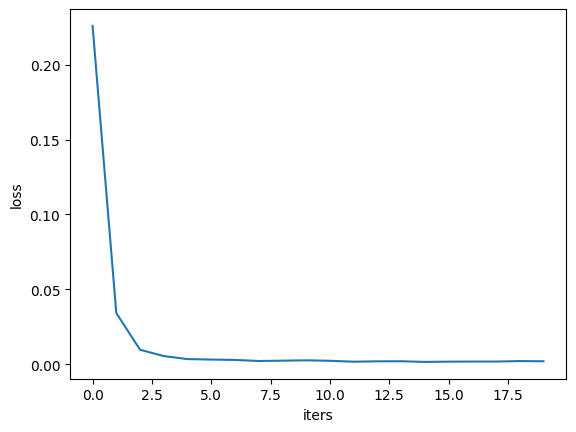

In [9]:
# manually added due to using mps
all_losses_numpy = [tensor.detach().cpu().numpy() for tensor in all_losses]

plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses_numpy)
plt.show()

#### Evaluation: A Sample of Generated Sequence

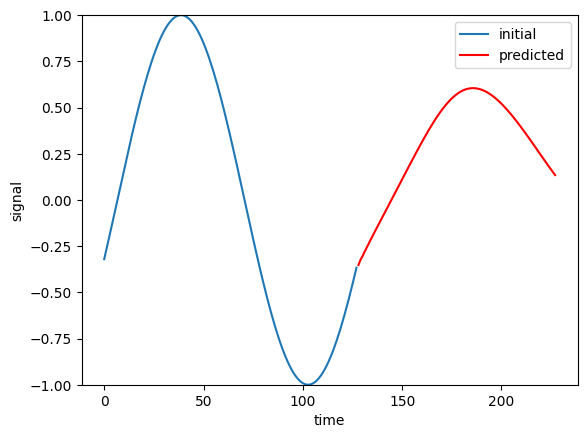

In [10]:
init_seq, predicted_seq = eval_step(net, predicted_len=100)
init_t      = np.arange(0, len(init_seq))
predicted_t = np.arange(len(init_seq), len(init_seq)+len(predicted_seq))
plt.plot(init_t, init_seq, label='initial')
plt.plot(predicted_t, predicted_seq, color='red', label='predicted')
plt.legend()
plt.ylim([-1, 1])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()